Import neccessary packages

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 30
INIT_LR = 6e-4
BS = 32
width=256
height=256
default_image_size = tuple((width, height))
image_size = 0
directory_root = 'input/plantvillage/'
depth=3

Function to convert images to array

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    print(directory_root)
    root_dir = listdir(directory_root)
    for directory in root_dir :
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        for disease_folder in plant_disease_folder_list :
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)
            if disease_folder == ".ipynb_checkpoints" :
                plant_disease_folder_list.remove(disease_folder)
            if "Untitled" in disease_folder :
                plant_disease_folder_list.remove(disease_folder)
                
        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:500]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
input/plantvillage/
[INFO] Processing Potato__healthy ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Bacterial_spot ...
[INFO] Processing Pepper_bell__healthy ...
[INFO] Processing Pepper_bell__Bacterial_spot ...
[INFO] Processing Potato__Early_blight ...
[INFO] Processing Potato__Late_blight ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato__Healthy ...
[INFO] Image loading completed


Get Size of Processed Image

In [5]:
image_size = len(image_list)

In [6]:
image_size

4522

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:
image_labels.sum(axis = 0)

array([499, 499, 500, 500, 152, 500, 500, 500, 499, 373])

In [9]:
label_binarizer.classes_

array(['Pepper_bell__Bacterial_spot', 'Pepper_bell__healthy',
       'Potato__Early_blight', 'Potato__Late_blight', 'Potato__healthy',
       'Tomato__Bacterial_spot', 'Tomato__Healthy', 'Tomato__Target_Spot',
       'Tomato__Tomato_YellowLeaf__Curl_Virus',
       'Tomato__Tomato_mosaic_virus'], dtype='<U37')

In [10]:
pcc = dict(zip(label_binarizer.classes_, image_labels.sum(axis = 0)))
pcc

{'Pepper_bell__Bacterial_spot': 499,
 'Pepper_bell__healthy': 499,
 'Potato__Early_blight': 500,
 'Potato__Late_blight': 500,
 'Potato__healthy': 152,
 'Tomato__Bacterial_spot': 500,
 'Tomato__Healthy': 500,
 'Tomato__Target_Spot': 500,
 'Tomato__Tomato_YellowLeaf__Curl_Virus': 499,
 'Tomato__Tomato_mosaic_virus': 373}

<BarContainer object of 10 artists>

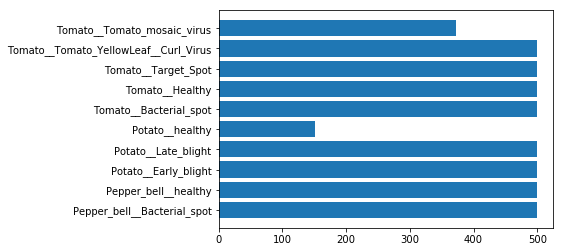

In [11]:
plt.barh(list(pcc.keys()), list(pcc.values()))

In [12]:
np.sum([(x/8519)**2 for x in image_labels.sum(axis = 0)])

0.029752459721412102

Print the classes

In [13]:
np_image_list = np.array(image_list) / 255.0

In [14]:
def do_a_run(rstate = 200):
    x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.25, random_state = 100)
    aug = ImageDataGenerator(
        rotation_range=30, height_shift_range=0.15, shear_range=0.15, 
        zoom_range=0.2,horizontal_flip=True, 
        fill_mode="nearest")
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1
    model.add(Conv2D(64, (2, 2), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(n_classes))
    model.add(Activation("softmax"))

    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss="binary_crossentropy", optimizer= opt, metrics=["accuracy"])
    from tensorflow.keras.callbacks import ModelCheckpoint
    filepath="BEST-256x256-rstate-"+str(rstate) + "-weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    history = model.fit_generator(
        aug.flow(x_train, y_train, batch_size=BS),
        validation_data=(x_test, y_test),
        steps_per_epoch=len(x_train) // BS,
        epochs=EPOCHS, verbose=1, callbacks=callbacks_list)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()

    return acc, val_acc, loss, val_loss, epochs

In [15]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.25, random_state = 100)
aug = ImageDataGenerator(
    rotation_range=30, height_shift_range=0.15, shear_range=0.15, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(64, (2, 2), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer= opt, metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      832       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0

Model Summary

Epoch 1/30
104/105 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9372
Epoch 00001: val_accuracy improved from -inf to 0.82228, saving model to BEST-256x256-rstate-100-weights-improvement-01-0.82.hdf5
105/105 [==============================] - 17s 163ms/step - loss: 0.1751 - accuracy: 0.9375 - val_loss: 1.0676 - val_accuracy: 0.8223
Epoch 2/30
104/105 [============================>.] - ETA: 0s - loss: 0.0849 - accuracy: 0.9693
Epoch 00002: val_accuracy improved from 0.82228 to 0.82405, saving model to BEST-256x256-rstate-100-weights-improvement-02-0.82.hdf5
105/105 [==============================] - 16s 154ms/step - loss: 0.0850 - accuracy: 0.9693 - val_loss: 0.9059 - val_accuracy: 0.8240
Epoch 3/30
104/105 [============================>.] - ETA: 0s - loss: 0.0757 - accuracy: 0.9722
Epoch 00003: val_accuracy improved from 0.82405 to 0.89080, saving model to BEST-256x256-rstate-100-weights-improvement-03-0.89.hdf5
105/105 [==============================] - 15s 1

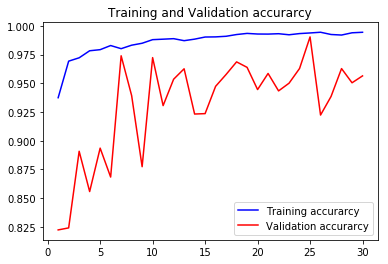

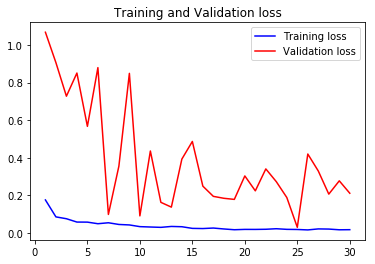

In [15]:
acc1, val_acc1, loss1, val_loss1, epochs1 = do_a_run(rstate=100)

Epoch 1/30
104/105 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9391
Epoch 00001: val_accuracy improved from -inf to 0.82334, saving model to BEST-256x256-rstate-200-weights-improvement-01-0.82.hdf5
105/105 [==============================] - 16s 149ms/step - loss: 0.1718 - accuracy: 0.9394 - val_loss: 1.3689 - val_accuracy: 0.8233
Epoch 2/30
104/105 [============================>.] - ETA: 0s - loss: 0.0971 - accuracy: 0.9635
Epoch 00002: val_accuracy did not improve from 0.82334
105/105 [==============================] - 15s 144ms/step - loss: 0.0971 - accuracy: 0.9634 - val_loss: 1.8149 - val_accuracy: 0.8233
Epoch 3/30
104/105 [============================>.] - ETA: 0s - loss: 0.0746 - accuracy: 0.9729
Epoch 00003: val_accuracy improved from 0.82334 to 0.82414, saving model to BEST-256x256-rstate-200-weights-improvement-03-0.82.hdf5
105/105 [==============================] - 16s 153ms/step - loss: 0.0745 - accuracy: 0.9728 - val_loss: 1.3302 - val_accuracy:

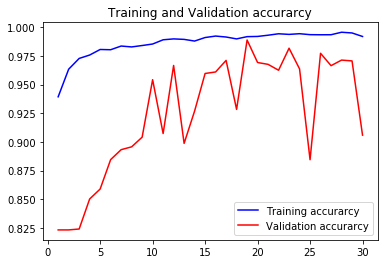

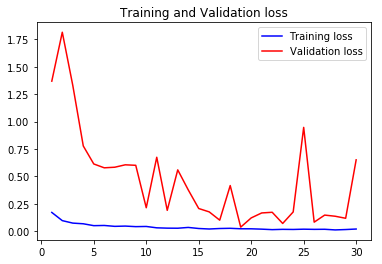

In [17]:
acc2, val_acc2, loss2, val_loss2, epochs2 = do_a_run(rstate=200)

Epoch 1/30
104/105 [============================>.] - ETA: 0s - loss: 0.1788 - accuracy: 0.9375
Epoch 00001: val_accuracy improved from -inf to 0.83696, saving model to BEST-256x256-rstate-300-weights-improvement-01-0.84.hdf5
105/105 [==============================] - 16s 150ms/step - loss: 0.1784 - accuracy: 0.9376 - val_loss: 1.1545 - val_accuracy: 0.8370
Epoch 2/30
104/105 [============================>.] - ETA: 0s - loss: 0.1034 - accuracy: 0.9620
Epoch 00002: val_accuracy improved from 0.83696 to 0.83722, saving model to BEST-256x256-rstate-300-weights-improvement-02-0.84.hdf5
105/105 [==============================] - 16s 148ms/step - loss: 0.1029 - accuracy: 0.9622 - val_loss: 0.8893 - val_accuracy: 0.8372
Epoch 3/30
104/105 [============================>.] - ETA: 0s - loss: 0.0792 - accuracy: 0.9717
Epoch 00003: val_accuracy improved from 0.83722 to 0.83767, saving model to BEST-256x256-rstate-300-weights-improvement-03-0.84.hdf5
105/105 [==============================] - 16s 1

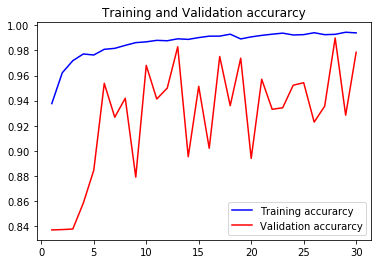

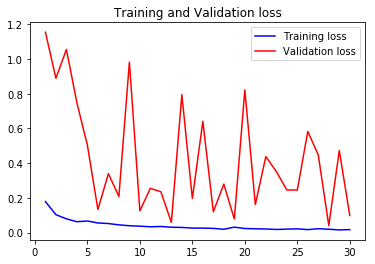

In [18]:
acc3, val_acc3, loss3, val_loss3, epochs3 = do_a_run(rstate=300)

Epoch 1/30
104/105 [============================>.] - ETA: 0s - loss: 0.1762 - accuracy: 0.9373
Epoch 00001: val_accuracy improved from -inf to 0.82334, saving model to BEST-256x256-rstate-400-weights-improvement-01-0.82.hdf5
105/105 [==============================] - 16s 154ms/step - loss: 0.1760 - accuracy: 0.9374 - val_loss: 1.7352 - val_accuracy: 0.8233
Epoch 2/30
104/105 [============================>.] - ETA: 0s - loss: 0.0995 - accuracy: 0.9635
Epoch 00002: val_accuracy improved from 0.82334 to 0.82440, saving model to BEST-256x256-rstate-400-weights-improvement-02-0.82.hdf5
105/105 [==============================] - 15s 147ms/step - loss: 0.0993 - accuracy: 0.9634 - val_loss: 1.1947 - val_accuracy: 0.8244
Epoch 3/30
104/105 [============================>.] - ETA: 0s - loss: 0.0782 - accuracy: 0.9710
Epoch 00003: val_accuracy improved from 0.82440 to 0.83103, saving model to BEST-256x256-rstate-400-weights-improvement-03-0.83.hdf5
105/105 [==============================] - 16s 1

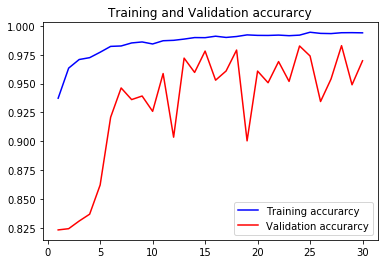

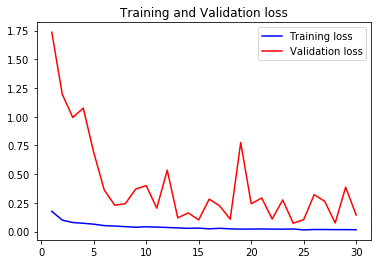

In [21]:
acc4, val_acc4, loss4, val_loss4, epochs4 = do_a_run(rstate=400)

In [22]:
acc5, val_acc5, loss5, val_loss5, epochs5 = do_a_run(rstate=500)

Epoch 1/30
104/105 [============================>.] - ETA: 0s - loss: 0.1878 - accuracy: 0.9338
Epoch 00001: val_accuracy improved from -inf to 0.82334, saving model to BEST-256x256-rstate-500-weights-improvement-01-0.82.hdf5
105/105 [==============================] - 16s 151ms/step - loss: 0.1870 - accuracy: 0.9340 - val_loss: 2.7155 - val_accuracy: 0.8233
Epoch 2/30
104/105 [============================>.] - ETA: 0s - loss: 0.1050 - accuracy: 0.9612
Epoch 00002: val_accuracy did not improve from 0.82334
105/105 [==============================] - 15s 142ms/step - loss: 0.1044 - accuracy: 0.9614 - val_loss: 2.7205 - val_accuracy: 0.8233
Epoch 3/30
104/105 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.9699
Epoch 00003: val_accuracy improved from 0.82334 to 0.82476, saving model to BEST-256x256-rstate-500-weights-improvement-03-0.82.hdf5
105/105 [==============================] - 16s 152ms/step - loss: 0.0800 - accuracy: 0.9700 - val_loss: 1.1505 - val_accuracy:

KeyboardInterrupt: 

In [23]:
val_accs = np.vstack([val_acc1,val_acc2,val_acc3,val_acc4])

In [24]:
np.max(np.sum(val_accs, axis = 0)/4)

0.9767463

In [25]:
from sklearn.metrics import confusion_matrix
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test);
print(f"Test Accuracy: {scores[1]*100}")
y_pred = np.rint(model.predict(x_test))
confmat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

[INFO] Calculating model accuracy


NameError: name 'model' is not defined

In [118]:
y_test.shape

(805, 9)

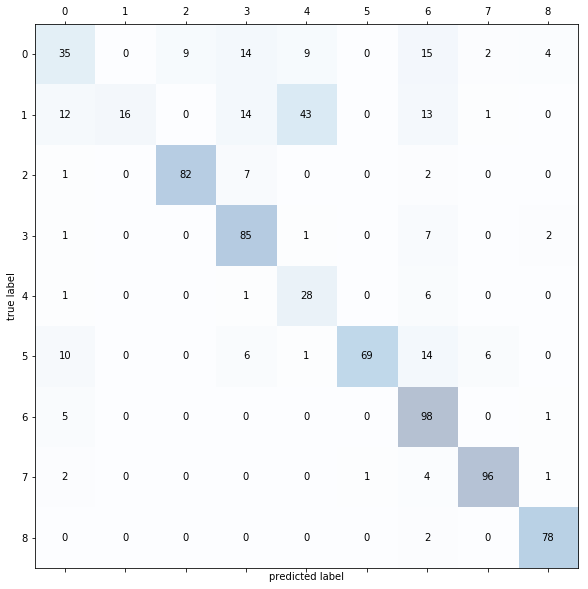

In [113]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_pred))

In [120]:
label_binarizer.classes_

array(['Pepper_bell__Bacterial_spot', 'Pepper_bell__healthy',
       'Potato__Early_blight', 'Potato__Late_blight', 'Potato__healthy',
       'Tomato__Bacterial_spot', 'Tomato__Target_Spot',
       'Tomato__Tomato_YellowLeaf__Curl_Virus',
       'Tomato__Tomato_mosaic_virus'], dtype='<U37')

In [114]:
len(label_list)

4022

In [25]:
x_test.dtype

dtype('float16')

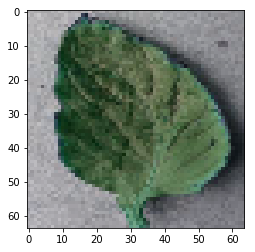

In [26]:
plt.imshow(x_test[10].astype('float32'))

In [27]:
y_test[0]

array([0, 0, 0, 1, 0, 0, 0, 0, 0])

In [40]:
def convert_image_to_array_spec(image_dir, size = 256):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (size,size))   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

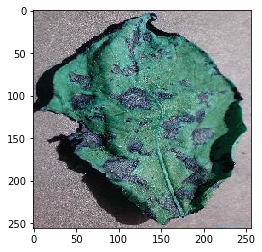

In [41]:
plt.imshow(convert_image_to_array_spec('input/plantvillage/plants/Potato__Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG')/255)

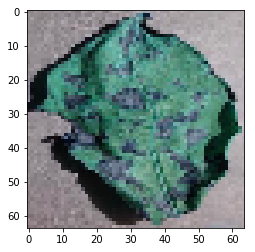

In [42]:
plt.imshow(convert_image_to_array_spec('input/plantvillage/plants/Potato__Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG', size = 64)/255)

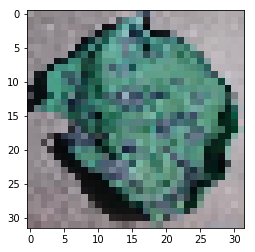

In [43]:
plt.imshow(convert_image_to_array_spec('input/plantvillage/plants/Potato__Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG', size = 32)/255)

In [45]:
label_binarizer.classes_

array(['Pepper_bell__Bacterial_spot', 'Pepper_bell__healthy',
       'Potato__Early_blight', 'Potato__Late_blight', 'Potato__healthy',
       'Tomato__Bacterial_spot', 'Tomato__Target_Spot',
       'Tomato__Tomato_YellowLeaf__Curl_Virus',
       'Tomato__Tomato_mosaic_virus'], dtype='<U37')